In [1]:
# === ra-cnn-custom.ipynb — Block 1: Setup & Datasets ===
# Paper mapping:
# - §5.1 Settings: datasets, augmentation only on D (train) not on D' (candidate set)
# - §2.3 Retrieval Engine: φ′(x) computed over D' (candidate set) without augmentation
# - §5.1 Evaluation metric: normalized L2 dissimilarity

import os, math, random, json, time
from pathlib import Path

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

# ----------------------------
# Reproducibility & device
# ----------------------------
SEED = 1234
random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED); torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
AMP = True  # mixed precision for speed on RTX 50xx / T4

# ----------------------------
# Paths & simple config
# ----------------------------
ROOT = Path(".").resolve()
# ✅ changed: use shared root-level data folder so both notebooks reuse same CIFAR-10
DATA_DIR = ROOT.parent / "data"

ARTIFACTS = ROOT / "artifacts"
CHECKPOINTS = ROOT / "checkpoints"
RESULTS = ROOT / "results"
FIGS = ROOT / "figures"


for p in [ARTIFACTS, CHECKPOINTS, RESULTS, FIGS]:
    p.mkdir(parents=True, exist_ok=True)

CONFIG = {
    "seed": SEED,
    "device": str(DEVICE),
    "amp": AMP,
    "baseline": {"epochs": 40, "min_epochs": 20, "early_patience": 8, "batch_size": 128, "lr": 1e-3, "wd": 5e-4},
    "racnn":    {"epochs": 30, "min_epochs": 15, "early_patience": 6, "batch_size": 128, "lr": 1e-3, "wd": 5e-4},
    "K_values": [5, 10],
    "mixup": {"NMU": 5},
    "eps_grid_l2": [1e-5, 2e-5, 8e-5, 1e-4, 2e-4, 4e-4],
    "pgd": {"steps": 10, "rand_start": True}
}

with open(ROOT / "config.json", "w") as f:
    json.dump(CONFIG, f, indent=2)

# ----------------------------
# CIFAR-10 normalization
# ----------------------------
CIFAR10_MEAN = (0.4914, 0.4822, 0.4465)
CIFAR10_STD  = (0.2470, 0.2435, 0.2616)

# ----------------------------
# Transforms
# ----------------------------
train_transform_aug = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(CIFAR10_MEAN, CIFAR10_STD),
])

plain_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(CIFAR10_MEAN, CIFAR10_STD),
])

# ----------------------------
# Datasets
# ----------------------------
# ✅ changed: set download=False everywhere because dataset already exists
train_aug_ds   = datasets.CIFAR10(root=DATA_DIR, train=True,  download=False, transform=train_transform_aug)
train_plain_ds = datasets.CIFAR10(root=DATA_DIR, train=True,  download=False, transform=plain_transform)
test_ds        = datasets.CIFAR10(root=DATA_DIR, train=False, download=False, transform=plain_transform)

# ----------------------------
# Loaders
# ----------------------------
BATCH_TRAIN = CONFIG["baseline"]["batch_size"]
BATCH_EVAL  = 256

train_aug_loader   = DataLoader(train_aug_ds,   batch_size=BATCH_TRAIN, shuffle=True,  num_workers=4, pin_memory=True)
train_plain_loader = DataLoader(train_plain_ds, batch_size=BATCH_EVAL,  shuffle=False, num_workers=4, pin_memory=True)
test_loader        = DataLoader(test_ds,        batch_size=BATCH_EVAL,  shuffle=False, num_workers=4, pin_memory=True)

# ----------------------------
# Normalized L2 helper (§5.1)
# ----------------------------
def normalized_l2(x, x_adv):
    """
    Paper §5.1 metric:
      L2_norm(x, x_adv) / (dim(x) * (max(x)-min(x))^2)
    """
    mean = torch.tensor(CIFAR10_MEAN, device=x.device).view(1,3,1,1)
    std  = torch.tensor(CIFAR10_STD,  device=x.device).view(1,3,1,1)
    x_raw     = x * std + mean
    x_adv_raw = x_adv * std + mean
    diff = (x_raw - x_adv_raw).view(x.shape[0], -1)
    l2sq = (diff ** 2).sum(dim=1)
    dim  = diff.shape[1]
    return l2sq / dim  # (max-min)^2 = 1^2 for [0,1] pixels

print(f"Device: {DEVICE}, AMP={AMP}")
print(f"Train batches: {len(train_aug_loader)}, Train-plain (D') batches: {len(train_plain_loader)}, Test batches: {len(test_loader)}")


Device: cuda, AMP=True
Train batches: 391, Train-plain (D') batches: 196, Test batches: 40


In [2]:
# === Block 2: CNN Backbone (φ′ and g) — EXACT from Appendix §7 ===
# Paper Table ("Appendix: Model details")

class FeatureExtractor(nn.Module):
    """
    φ or φ′ — as described in Appendix §7:
      6 conv layers, specific strides and channel sizes.
    Output feature map ≈ [B,192,4,4].
    """
    def __init__(self):
        super().__init__()
        self.features = nn.Sequential(
            # 1st conv block
            nn.Conv2d(3, 96, kernel_size=3, stride=1, padding=1),   # 32→30
            nn.BatchNorm2d(96),

            # 2nd conv block
            nn.Conv2d(96, 96, kernel_size=3, stride=1, padding=1),  # 30→28
            nn.BatchNorm2d(96),
            nn.ReLU(inplace=True),

            # 3rd conv block (stride 2)
            nn.Conv2d(96, 96, kernel_size=3, stride=2, padding=1),  # 28→13
            nn.BatchNorm2d(96),
            nn.ReLU(inplace=True),

            # 4th conv block
            nn.Conv2d(96, 192, kernel_size=3, stride=1, padding=1), # 13→11
            nn.BatchNorm2d(192),
            nn.ReLU(inplace=True),

            # 5th conv block (stride 2)
            nn.Conv2d(192, 192, kernel_size=3, stride=2, padding=1), # 11→4
            nn.BatchNorm2d(192),
            
            # final normalization
            nn.BatchNorm2d(192)
        )
        self.out_dim = 192 * 8 * 8

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        return x


class Classifier(nn.Module):
    """
    Classifier g from Appendix Table:
      FC 256→64→10 (with BN + ReLU on first FC)
    """
    def __init__(self, in_dim=3072, num_classes=10):
        super().__init__()
        self.classifier = nn.Sequential(
            nn.Linear(in_dim, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(inplace=True),
            nn.Linear(64, num_classes)
        )

    def forward(self, x):
        return self.classifier(x)


class BaselineCNN(nn.Module):
    """φ′ + g — baseline CNN for pretraining"""
    def __init__(self, num_classes=10):
        super().__init__()
        self.feature_extractor = FeatureExtractor()
        self.classifier = Classifier(self.feature_extractor.out_dim, num_classes)

    def forward(self, x):
        feats = self.feature_extractor(x)
        logits = self.classifier(feats)
        return logits


baseline_model = BaselineCNN(num_classes=10).to(DEVICE)
print(f"Baseline CNN (Appendix version) params: {sum(p.numel() for p in baseline_model.parameters())/1e6:.2f} M")


Baseline CNN (Appendix version) params: 1.46 M


In [3]:
x = torch.randn(1, 3, 32, 32).to(DEVICE)
feats = baseline_model.feature_extractor(x)
print("Feature shape:", feats.shape)  # should be [1, 12288]


Feature shape: torch.Size([1, 12288])


In [ ]:
# # === Block 3: Baseline Training (φ′ + g′) ===
# # --------------------------------------------------------------
# # Train the baseline CNN classifier as in §5.1 and §5.2.
# # This will later provide the retrieval feature extractor φ′.
# # --------------------------------------------------------------

# import copy
# from torch.optim import Adam
# from torch.cuda.amp import GradScaler, autocast
# from tqdm import tqdm

# # --------------------------------------------------------------
# # Hyperparameters & setup
# # --------------------------------------------------------------
# EPOCHS = CONFIG["baseline"]["epochs"]
# LR      = CONFIG["baseline"]["lr"]
# WD      = CONFIG["baseline"]["wd"]
# BATCH   = CONFIG["baseline"]["batch_size"]
# PATIENCE= CONFIG["baseline"]["early_patience"]
# MIN_E   = CONFIG["baseline"]["min_epochs"]

# criterion = nn.CrossEntropyLoss()
# optimizer = Adam(baseline_model.parameters(), lr=LR, weight_decay=WD)
# scaler = GradScaler(enabled=AMP)

# # simple train/val split (10% val)
# n_total = len(train_aug_ds)
# n_val   = int(0.1 * n_total)
# n_train = n_total - n_val
# train_ds, val_ds = torch.utils.data.random_split(train_aug_ds, [n_train, n_val])
# train_loader = DataLoader(train_ds, batch_size=BATCH, shuffle=True,  num_workers=4, pin_memory=True)
# val_loader   = DataLoader(val_ds,   batch_size=BATCH, shuffle=False, num_workers=4, pin_memory=True)

# print(f"Training on {len(train_ds)} images, validating on {len(val_ds)} images.")

# # --------------------------------------------------------------
# # Utility: accuracy function
# # --------------------------------------------------------------
# def accuracy_fn(logits, targets):
#     preds = logits.argmax(dim=1)
#     return (preds == targets).float().mean().item()

# # --------------------------------------------------------------
# # Training loop with early stopping and checkpoint
# # --------------------------------------------------------------
# best_val_acc = 0.0
# best_model_wts = copy.deepcopy(baseline_model.state_dict())
# epochs_no_improve = 0

# for epoch in range(1, EPOCHS+1):
#     baseline_model.train()
#     train_loss, train_acc = 0.0, 0.0

#     for imgs, labels in tqdm(train_loader, desc=f"[Epoch {epoch}/{EPOCHS}] Train", leave=False):
#         imgs, labels = imgs.to(DEVICE), labels.to(DEVICE)
#         optimizer.zero_grad(set_to_none=True)

#         with autocast(enabled=AMP):
#             outputs = baseline_model(imgs)
#             loss = criterion(outputs, labels)

#         scaler.scale(loss).backward()
#         scaler.step(optimizer)
#         scaler.update()

#         train_loss += loss.item() * imgs.size(0)
#         train_acc  += accuracy_fn(outputs, labels) * imgs.size(0)

#     train_loss /= len(train_loader.dataset)
#     train_acc  /= len(train_loader.dataset)

#     # -------------------- Validation --------------------
#     baseline_model.eval()
#     val_loss, val_acc = 0.0, 0.0
#     with torch.no_grad():
#         for imgs, labels in tqdm(val_loader, desc=f"[Epoch {epoch}] Val", leave=False):
#             imgs, labels = imgs.to(DEVICE), labels.to(DEVICE)
#             with autocast(enabled=AMP):
#                 outputs = baseline_model(imgs)
#                 loss = criterion(outputs, labels)

#             val_loss += loss.item() * imgs.size(0)
#             val_acc  += accuracy_fn(outputs, labels) * imgs.size(0)

#     val_loss /= len(val_loader.dataset)
#     val_acc  /= len(val_loader.dataset)

#     print(f"Epoch {epoch:02d}: train_loss={train_loss:.4f} "
#           f"train_acc={train_acc:.4f} val_loss={val_loss:.4f} val_acc={val_acc:.4f}")

#     # -------------------- Early stopping --------------------
#     if val_acc > best_val_acc:
#         best_val_acc = val_acc
#         best_model_wts = copy.deepcopy(baseline_model.state_dict())
#         epochs_no_improve = 0
#         torch.save(best_model_wts, CHECKPOINTS / "baseline_best.pt")
#     else:
#         epochs_no_improve += 1

#     if epoch > MIN_E and epochs_no_improve >= PATIENCE:
#         print(f"⏹ Early stopping at epoch {epoch} (no improvement for {PATIENCE} epochs).")
#         break

# # --------------------------------------------------------------
# # Load best weights and evaluate on clean test set (§5.2)
# # --------------------------------------------------------------
# baseline_model.load_state_dict(best_model_wts)
# baseline_model.eval()
# test_acc = 0.0
# with torch.no_grad():
#     for imgs, labels in tqdm(test_loader, desc="Test (clean)"):
#         imgs, labels = imgs.to(DEVICE), labels.to(DEVICE)
#         outputs = baseline_model(imgs)
#         test_acc += accuracy_fn(outputs, labels) * imgs.size(0)

# test_acc /= len(test_loader.dataset)
# print(f"\n✅ Clean Test Accuracy (Baseline φ′+g′): {test_acc*100:.2f}% "
#       f"| Saved best checkpoint to checkpoints/baseline_best.pt")


C:\Users\User\AppData\Local\Temp\ipykernel_13012\3468669963.py:24: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=AMP)


Training on 45000 images, validating on 5000 images.


[Epoch 1/40] Train:   0%|          | 0/352 [00:00<?, ?it/s]C:\Users\User\AppData\Local\Temp\ipykernel_13012\3468669963.py:58: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=AMP):
[Epoch 1] Val:   0%|          | 0/40 [00:00<?, ?it/s]                 C:\Users\User\AppData\Local\Temp\ipykernel_13012\3468669963.py:78: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=AMP):


Epoch 01: train_loss=1.4645 train_acc=0.4699 val_loss=1.2696 val_acc=0.5518


Epoch 02: train_loss=1.0495 train_acc=0.6242 val_loss=1.0101 val_acc=0.6352


Epoch 03: train_loss=0.8929 train_acc=0.6846 val_loss=0.9435 val_acc=0.6700


Epoch 04: train_loss=0.8076 train_acc=0.7162 val_loss=0.8431 val_acc=0.7058


Epoch 05: train_loss=0.7472 train_acc=0.7394 val_loss=0.7827 val_acc=0.7292


Epoch 06: train_loss=0.7001 train_acc=0.7551 val_loss=0.8305 val_acc=0.7124


Epoch 07: train_loss=0.6606 train_acc=0.7691 val_loss=0.7167 val_acc=0.7482


Epoch 08: train_loss=0.6311 train_acc=0.7797 val_loss=0.7209 val_acc=0.7500


Epoch 09: train_loss=0.6068 train_acc=0.7893 val_loss=0.6840 val_acc=0.7622


Epoch 10: train_loss=0.5801 train_acc=0.7992 val_loss=0.6729 val_acc=0.7636


Epoch 11: train_loss=0.5578 train_acc=0.8059 val_loss=0.6518 val_acc=0.7698


Epoch 12: train_loss=0.5423 train_acc=0.8123 val_loss=0.6191 val_acc=0.7840


Epoch 13: train_loss=0.5252 train_acc=0.8178 val_loss=0.5947 val_acc=0.7980


Epoch 14: train_loss=0.5141 train_acc=0.8226 val_loss=0.5922 val_acc=0.7940


Epoch 15: train_loss=0.4924 train_acc=0.8288 val_loss=0.5489 val_acc=0.8120


Epoch 16: train_loss=0.4785 train_acc=0.8348 val_loss=0.6485 val_acc=0.7822


Epoch 17: train_loss=0.4665 train_acc=0.8384 val_loss=0.6054 val_acc=0.7888


Epoch 18: train_loss=0.4557 train_acc=0.8409 val_loss=0.6076 val_acc=0.7992


Epoch 19: train_loss=0.4425 train_acc=0.8479 val_loss=0.5844 val_acc=0.7988


Epoch 20: train_loss=0.4316 train_acc=0.8515 val_loss=0.5745 val_acc=0.8066


Epoch 21: train_loss=0.4221 train_acc=0.8538 val_loss=0.5221 val_acc=0.8216


Epoch 22: train_loss=0.4173 train_acc=0.8574 val_loss=0.5648 val_acc=0.8010


Epoch 23: train_loss=0.4090 train_acc=0.8591 val_loss=0.5201 val_acc=0.8188


Epoch 24: train_loss=0.3963 train_acc=0.8623 val_loss=0.4854 val_acc=0.8302


Epoch 25: train_loss=0.3895 train_acc=0.8650 val_loss=0.5391 val_acc=0.8188


Epoch 26: train_loss=0.3825 train_acc=0.8686 val_loss=0.4916 val_acc=0.8312


Epoch 27: train_loss=0.3829 train_acc=0.8691 val_loss=0.4933 val_acc=0.8294


Epoch 28: train_loss=0.3729 train_acc=0.8707 val_loss=0.4998 val_acc=0.8282


Epoch 29: train_loss=0.3673 train_acc=0.8730 val_loss=0.4840 val_acc=0.8322


Epoch 30: train_loss=0.3625 train_acc=0.8746 val_loss=0.4820 val_acc=0.8374


Epoch 31: train_loss=0.3582 train_acc=0.8753 val_loss=0.5055 val_acc=0.8244


Epoch 32: train_loss=0.3551 train_acc=0.8773 val_loss=0.4819 val_acc=0.8384


Epoch 33: train_loss=0.3466 train_acc=0.8795 val_loss=0.4937 val_acc=0.8298


Epoch 34: train_loss=0.3424 train_acc=0.8832 val_loss=0.4757 val_acc=0.8376


Epoch 35: train_loss=0.3413 train_acc=0.8832 val_loss=0.5008 val_acc=0.8340


Epoch 36: train_loss=0.3379 train_acc=0.8835 val_loss=0.4600 val_acc=0.8420


Epoch 37: train_loss=0.3360 train_acc=0.8833 val_loss=0.5295 val_acc=0.8202


Epoch 38: train_loss=0.3323 train_acc=0.8832 val_loss=0.4947 val_acc=0.8342


Epoch 39: train_loss=0.3298 train_acc=0.8844 val_loss=0.5077 val_acc=0.8280


Epoch 40: train_loss=0.3272 train_acc=0.8867 val_loss=0.4857 val_acc=0.8348


Test (clean): 100%|██████████| 40/40 [00:09<00:00,  4.26it/s]


✅ Clean Test Accuracy (Baseline φ′+g′): 86.38% | Saved best checkpoint to checkpoints/baseline_best.pt


In [4]:
ckpt = torch.load(CHECKPOINTS / "baseline_best.pt", map_location="cpu")
print(ckpt.keys())


odict_keys(['feature_extractor.features.0.weight', 'feature_extractor.features.0.bias', 'feature_extractor.features.1.weight', 'feature_extractor.features.1.bias', 'feature_extractor.features.1.running_mean', 'feature_extractor.features.1.running_var', 'feature_extractor.features.1.num_batches_tracked', 'feature_extractor.features.2.weight', 'feature_extractor.features.2.bias', 'feature_extractor.features.3.weight', 'feature_extractor.features.3.bias', 'feature_extractor.features.3.running_mean', 'feature_extractor.features.3.running_var', 'feature_extractor.features.3.num_batches_tracked', 'feature_extractor.features.5.weight', 'feature_extractor.features.5.bias', 'feature_extractor.features.6.weight', 'feature_extractor.features.6.bias', 'feature_extractor.features.6.running_mean', 'feature_extractor.features.6.running_var', 'feature_extractor.features.6.num_batches_tracked', 'feature_extractor.features.8.weight', 'feature_extractor.features.8.bias', 'feature_extractor.features.9.wei

In [ ]:
# # === Block 4: Retrieval Engine F — FAISS implementation ===
# # Paper mapping:
# # - §2.3 Retrieval Engine F : “pretrained φ′ used to embed D′”
# # - §5.1 Settings           : “no augmentation on D′”
# # - retrieval goal          : build index over φ′(x′) for all candidate samples in D′

# import faiss
# import pickle
# from tqdm import tqdm

# # ----------------------------
# # 1️⃣ Load pretrained φ′ (feature extractor only)
# # ----------------------------
# baseline_ckpt = torch.load(CHECKPOINTS / "baseline_best.pt", map_location=DEVICE)

# # Extract only φ′ weights (ignore classifier)
# phi_dict = {k.replace("feature_extractor.", ""): v
#             for k, v in baseline_ckpt.items()
#             if k.startswith("feature_extractor.")}

# phi = FeatureExtractor().to(DEVICE)
# phi.load_state_dict(phi_dict, strict=False)
# phi.eval()
# for p in phi.parameters():
#     p.requires_grad = False

# print("✅ Loaded pretrained feature extractor φ′ for retrieval engine (filtered from baseline).")


# # ----------------------------
# # 2️⃣ Embed all D′ (train_plain_ds)
# # ----------------------------
# all_feats, all_labels = [], []

# with torch.no_grad():
#     for imgs, labels in tqdm(train_plain_loader, desc="Embedding D′", ncols=100):
#         imgs = imgs.to(DEVICE)
#         feats = phi(imgs)                     # φ′(x′)
#         feats = F.normalize(feats, p=2, dim=1)  # L2-normalize improves distance stability
#         all_feats.append(feats.cpu())
#         all_labels.append(labels)

# all_feats  = torch.cat(all_feats)
# all_labels = torch.cat(all_labels)

# print(f"Feature matrix: {all_feats.shape}, Labels: {all_labels.shape}")

# # ----------------------------
# # 3️⃣ Build FAISS index (L2 metric)
# # ----------------------------
# d = all_feats.shape[1]  # feature dimension, should be 3072
# index = faiss.IndexFlatL2(d)  # exact search with L2
# index.add(all_feats.numpy().astype('float32'))
# print(f"✅ FAISS index built with {index.ntotal} vectors of dim {d}")

# # ----------------------------
# # 4️⃣ Save artifacts
# # ----------------------------
# torch.save(all_feats, ARTIFACTS / "features_train_plain.pt")
# torch.save(all_labels, ARTIFACTS / "labels_train_plain.pt")
# faiss.write_index(index, str(ARTIFACTS / "faiss_index.bin"))
# print("💾 Saved retrieval engine artifacts (features, labels, index)")

# # ----------------------------
# # 5️⃣ Retrieval helper
# # ----------------------------
# class RetrievalEngine:
#     """
#     F(x): returns indices + labels of top-K nearest neighbors from D′.
#     Paper §2.3 : uses φ′(x) as query key.
#     """
#     def __init__(self, feature_extractor, index, features, labels):
#         self.phi = feature_extractor.eval()
#         self.index = index
#         self.features = features
#         self.labels = labels

#     def retrieve(self, x, K=5):
#         with torch.no_grad():
#             feats = self.phi(x.to(DEVICE))
#             feats = F.normalize(feats, p=2, dim=1)
#             D, I = self.index.search(feats.cpu().numpy().astype('float32'), K)
#             retrieved_feats = self.features[I]
#             retrieved_labels = self.labels[I]
#         return torch.tensor(D), retrieved_feats, retrieved_labels

# # quick self-test
# retr_engine = RetrievalEngine(phi, index, all_feats, all_labels)
# print("🔍 Retrieval engine ready! Testing one query batch...")

# imgs, labels = next(iter(test_loader))
# D, feats, labs = retr_engine.retrieve(imgs[:2], K=5)
# print(f"Query→retrieval distances shape: {D.shape}, retrieved labels[0]: {labs[0].tolist()[:5]}")


✅ Loaded pretrained feature extractor φ′ for retrieval engine (filtered from baseline).


Embedding D′: 100%|███████████████████████████████████████████████| 196/196 [00:13<00:00, 14.92it/s]


Feature matrix: torch.Size([50000, 12288]), Labels: torch.Size([50000])
✅ FAISS index built with 50000 vectors of dim 12288
💾 Saved retrieval engine artifacts (features, labels, index)
🔍 Retrieval engine ready! Testing one query batch...
Query→retrieval distances shape: torch.Size([2, 5]), retrieved labels[0]: [5, 3, 3, 2, 6]


In [ ]:
# !pip uninstall faiss-cpu -y


Found existing installation: faiss-cpu 1.12.0
Uninstalling faiss-cpu-1.12.0:
  Successfully uninstalled faiss-cpu-1.12.0
Note: you may need to restart the kernel to use updated packages.


You can safely remove it manually.
You can safely remove it manually.


In [5]:
import faiss
print("FAISS version:", faiss.__version__)
print("Number of available GPUs:", faiss.get_num_gpus())
print("Has GPU symbols:", hasattr(faiss, "StandardGpuResources"))


FAISS version: 1.9.0
Number of available GPUs: 1
Has GPU symbols: True


In [6]:
import torch
print("Torch CUDA available:", torch.cuda.is_available())
print("Torch CUDA version:", torch.version.cuda)
print("GPU name:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "None")


Torch CUDA available: True
Torch CUDA version: 12.8
GPU name: NVIDIA GeForce RTX 5060 Ti


In [ ]:
# !pip install --upgrade --force-reinstall "numpy<2"


  Using cached numpy-1.26.4-cp310-cp310-win_amd64.whl.metadata (61 kB)
Using cached numpy-1.26.4-cp310-cp310-win_amd64.whl (15.8 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 2.2.6
    Uninstalling numpy-2.2.6:
      Successfully uninstalled numpy-2.2.6


  You can safely remove it manually.
  You can safely remove it manually.
  You can safely remove it manually.
  You can safely remove it manually.
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
opencv-python 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 1.26.4 which is incompatible.


In [7]:
# === Block 4 – Retrieval Engine F (GPU FAISS Implementation) ===
# Paper Mapping:
#   § 2.3 Retrieval Engine F – "pretrained φ′ used to embed D′"
#   § 5.1 Settings – "no augmentation on D′"
#   Goal – index φ′(x′) for all samples in D′ and enable fast K-NN lookup in feature space.

import faiss
from tqdm import tqdm
import torch.nn.functional as F

# ----------------------------
# 1️⃣ Load Pretrained Feature Extractor φ′ (only encoder part from baseline)
# ----------------------------
baseline_ckpt = torch.load(CHECKPOINTS / "baseline_best.pt", map_location=DEVICE)

# keep only φ′ weights from baseline
phi_dict = {
    k.replace("feature_extractor.", ""): v
    for k, v in baseline_ckpt.items()
    if k.startswith("feature_extractor.")
}

phi = FeatureExtractor().to(DEVICE)
phi.load_state_dict(phi_dict, strict=False)
phi.eval()
for p in phi.parameters():
    p.requires_grad = False

print("✅ Loaded pretrained feature extractor φ′ for retrieval engine (GPU mode).")

# ----------------------------
# 2️⃣ Embed All D′ (train_plain_loader, no augmentation)
# ----------------------------
all_feats, all_labels = [], []
with torch.no_grad():
    for imgs, labels in tqdm(train_plain_loader, desc="Embedding D′", ncols=100):
        imgs = imgs.to(DEVICE, non_blocking=True)
        feats = phi(imgs)
        feats = F.normalize(feats, p=2, dim=1)        # L2-normalize embeddings
        all_feats.append(feats.cpu())
        all_labels.append(labels)

all_feats  = torch.cat(all_feats)
all_labels = torch.cat(all_labels)
print(f"📊 Feature matrix: {all_feats.shape}, Labels: {all_labels.shape}")

# ----------------------------
# 3️⃣ Build FAISS GPU Index (L2 metric)
# ----------------------------
d = all_feats.shape[1]          # feature dimension ≈ 12288 for your architecture
res = faiss.StandardGpuResources()        # allocate GPU resources
cpu_index = faiss.IndexFlatL2(d)          # base CPU index (L2)
gpu_index = faiss.index_cpu_to_gpu(res, 0, cpu_index)   # move to GPU 0
gpu_index.add(all_feats.numpy().astype("float32"))
print(f"✅ FAISS GPU index built with {gpu_index.ntotal} vectors (dim {d}).")

# ----------------------------
# 4️⃣ Save Artifacts for Later Use in RaCNN Training
# ----------------------------
torch.save(all_feats, ARTIFACTS / "features_train_plain.pt")
torch.save(all_labels, ARTIFACTS / "labels_train_plain.pt")
faiss.write_index(faiss.index_gpu_to_cpu(gpu_index), str(ARTIFACTS / "faiss_index_cpu.bin"))
print("💾 Saved retrieval engine artifacts (features, labels, CPU-compatible index).")

# ----------------------------
# 5️⃣ Retrieval Helper Class F(x)
# ----------------------------
class RetrievalEngine:
    """
    F(x): returns indices + labels of top-K nearest neighbors from D′.
    Paper § 2.3: uses φ′(x) as query key.
    """
    def __init__(self, feature_extractor, index, features, labels):
        self.phi = feature_extractor.eval()
        self.index = index
        self.features = features
        self.labels = labels

    def retrieve(self, x, K=5):
        with torch.no_grad():
            feats = self.phi(x.to(DEVICE))
            feats = F.normalize(feats, p=2, dim=1)
            D, I = self.index.search(feats.cpu().numpy().astype("float32"), K)
            retrieved_feats  = self.features[I]
            retrieved_labels = self.labels[I]
        return torch.tensor(D), retrieved_feats, retrieved_labels

# ----------------------------
# 6️⃣ Quick Sanity Check on Retrieval
# ----------------------------
retr_engine = RetrievalEngine(phi, gpu_index, all_feats, all_labels)
imgs, labels = next(iter(test_loader))
D, feats, labs = retr_engine.retrieve(imgs[:2], K=5)
print(f"🔍 Distances shape: {D.shape} – Retrieved labels[0]: {labs[0].tolist()[:5]}")


✅ Loaded pretrained feature extractor φ′ for retrieval engine (GPU mode).


Embedding D′: 100%|███████████████████████████████████████████████| 196/196 [00:14<00:00, 13.37it/s]


📊 Feature matrix: torch.Size([50000, 12288]), Labels: torch.Size([50000])
✅ FAISS GPU index built with 50000 vectors (dim 12288).
💾 Saved retrieval engine artifacts (features, labels, CPU-compatible index).
🔍 Distances shape: torch.Size([2, 5]) – Retrieved labels[0]: [5, 3, 3, 2, 6]


In [8]:
# === Block 5-A — RaCNN Architecture (φ, U, g) ===
# Paper mapping:
#   § 2.1  "Trainable projection based on attention mechanism"
#   § 2.2  "Classifier g(P(x)) … locally linear behaviour"

class RaCNN(nn.Module):
    def __init__(self, retrieval_engine, feat_dim, num_classes=10, K=5):
        """
        retrieval_engine : pretrained FAISS-based RetrievalEngine F
        feat_dim         : dimensionality of φ(x)
        num_classes      : CIFAR-10 = 10
        K                : number of neighbors to retrieve (5 or 10)
        """
        super().__init__()
        self.retr_engine = retrieval_engine
        self.K = K

        # φ : a new feature extractor (same CNN as baseline, trainable)
        self.phi = FeatureExtractor()

        # U : the learnable projection matrix used in βₖ = φ(x′ₖ)ᵀ U φ(x)
        self.U = nn.Parameter(torch.eye(feat_dim))

        # g : classifier operating on projected feature P(x)
        self.g = Classifier(in_dim=feat_dim, num_classes=num_classes)

    # ---------------------------------------------------------------
    def forward(self, x):
        """
        Returns:
          logits, α, β, neighbor_feats, neighbor_labels
        """
        # Step 1 – compute current feature φ(x)
        z = self.phi(x)

        # Step 2 – retrieve K nearest neighbors from D′
        _, neigh_feats, neigh_labels = self.retr_engine.retrieve(x, K=self.K)
        neigh_feats, neigh_labels = neigh_feats.to(x.device), neigh_labels.to(x.device)

        # Step 3 – attention-based projection (§ 2.1)
        # βₖ = φ(x′ₖ)ᵀ U φ(x)
        beta = torch.einsum('bkd,dd,bd->bk', neigh_feats, self.U, z)

        # αₖ = softmax(βₖ)
        alpha = F.softmax(beta, dim=1)

        # P(x) = Σ αₖ φ(x′ₖ)
        proj = torch.einsum('bk,bkd->bd', alpha, neigh_feats)

        # Step 4 – classification on the projected feature
        logits = self.g(proj)

        return logits, alpha, beta, neigh_feats, neigh_labels


In [9]:
# === Block 5-B — Local Mixup (from §2.2) ===
import torch.nn.functional as F

def local_mixup(neigh_feats, neigh_labels, num_classes=10):
    """
    neigh_feats: [B, K, D]  → retrieved neighbor features
    neigh_labels: [B, K]    → integer class labels
    Returns:
        mix_feats  → mixed feature vector  [B, D]
        mix_labels → mixed soft labels     [B, num_classes]
    """

    B, K, D = neigh_feats.shape

    # Sample random convex coefficients αₖ ≥ 0, ∑ αₖ = 1
    alpha = torch.rand(B, K, device=neigh_feats.device)
    alpha = alpha / alpha.sum(dim=1, keepdim=True)   # normalize to simplex

    # Compute weighted sum of features:  ∑ αₖ φ(x′ₖ)
    mix_feats = torch.einsum('bk,bkd->bd', alpha, neigh_feats)

    # Convert labels to one-hot and mix the same way:  ∑ αₖ y′ₖ
    onehot = F.one_hot(neigh_labels, num_classes=num_classes).float()  # [B,K,C]
    mix_labels = torch.einsum('bk,bkc->bc', alpha, onehot)

    return mix_feats, mix_labels


In [10]:
# === Block 5-C — RaCNN Training Loop (K = 5) ===
from tqdm import tqdm

def train_racnn(model, train_loader, optimizer, epochs=30, NMU=5, AMP=True):
    """
    model      : RaCNN model (φ, U, g, F)
    train_loader : data loader with augmentations
    NMU        : number of local mixup updates per epoch
    AMP        : mixed-precision training (True for speed)
    """
    scaler = torch.amp.GradScaler("cuda", enabled=AMP)
    model.train()

    for epoch in range(1, epochs + 1):
        total_loss, total_correct, total_seen = 0.0, 0, 0
        progress = tqdm(train_loader, desc=f"[Epoch {epoch}/{epochs}]", ncols=90)

        for imgs, labels in progress:
            imgs, labels = imgs.to(DEVICE), labels.to(DEVICE)
            optimizer.zero_grad(set_to_none=True)

            # ----------- Normal classification step (NCE) -----------
            with torch.amp.autocast("cuda", enabled=AMP):
                logits, _, _, _, _ = model(imgs)
                loss_cls = F.cross_entropy(logits, labels)

            scaler.scale(loss_cls).backward()
            scaler.step(optimizer)
            scaler.update()

            # Accumulate stats
            preds = logits.argmax(1)
            total_correct += (preds == labels).sum().item()
            total_seen += labels.size(0)
            total_loss += loss_cls.item()

            # ----------- Local Mixup updates (NMU steps) -----------
            for _ in range(NMU):
                optimizer.zero_grad(set_to_none=True)
                _, _, _, neigh_feats, neigh_labels = model(imgs)
                mix_feats, mix_labels = local_mixup(neigh_feats, neigh_labels)
                with torch.amp.autocast("cuda", enabled=AMP):
                    logits_mix = model.g(mix_feats)
                    loss_mix = F.cross_entropy(logits_mix, mix_labels.argmax(dim=1))
                scaler.scale(loss_mix).backward()
                scaler.step(optimizer)
                scaler.update()

            progress.set_postfix({
                "loss": f"{total_loss / total_seen:.4f}",
                "acc": f"{100 * total_correct / total_seen:.2f}%"
            })

        print(f"Epoch {epoch:02d}: train_loss={total_loss/len(train_loader):.4f}, "
              f"train_acc={100*total_correct/total_seen:.2f}%")

    print("✅ Finished RaCNN training")


In [15]:
# === Block 5-C (fixed autocast syntax) — RaCNN (K=5) Training ===
import copy
from torch.cuda.amp import GradScaler
from tqdm import tqdm

def train_racnn_k5(model, train_loader, val_loader, optimizer,
                   epochs=30, NMU=5, AMP=True, min_epochs=10, patience=6):
    """
    RaCNN (K=5) training loop with:
    - early stopping
    - validation accuracy tracking
    - checkpoint saving
    """
    scaler = GradScaler(enabled=AMP)
    best_val_acc = 0.0
    best_weights = copy.deepcopy(model.state_dict())
    epochs_no_improve = 0

    for epoch in range(1, epochs + 1):
        model.train()
        total_loss, total_correct, total_seen = 0.0, 0, 0

        for imgs, labels in tqdm(train_loader, desc=f"[Epoch {epoch}/{epochs}] Train", ncols=90):
            imgs, labels = imgs.to(DEVICE), labels.to(DEVICE)
            optimizer.zero_grad(set_to_none=True)

            # --- Normal classification step (NCE) ---
            with torch.amp.autocast(device_type="cuda", enabled=AMP):
                logits, _, _, _, _ = model(imgs)
                loss_cls = F.cross_entropy(logits, labels)

            scaler.scale(loss_cls).backward()
            scaler.step(optimizer)
            scaler.update()

            preds = logits.argmax(1)
            total_correct += (preds == labels).sum().item()
            total_seen += labels.size(0)
            total_loss += loss_cls.item()

            # --- Local Mixup (NMU) updates ---
            for _ in range(NMU):
                optimizer.zero_grad(set_to_none=True)
                _, _, _, neigh_feats, neigh_labels = model(imgs)
                mix_feats, mix_labels = local_mixup(neigh_feats, neigh_labels)
                with torch.amp.autocast(device_type="cuda", enabled=AMP):
                    logits_mix = model.g(mix_feats)
                    loss_mix = F.cross_entropy(logits_mix, mix_labels.argmax(1))
                scaler.scale(loss_mix).backward()
                scaler.step(optimizer)
                scaler.update()

        train_acc = total_correct / total_seen
        train_loss = total_loss / len(train_loader)

        # --- Validation ---
        model.eval()
        val_loss, val_correct, val_seen = 0.0, 0, 0
        with torch.no_grad(), torch.amp.autocast(device_type="cuda", enabled=AMP):
            for imgs, labels in val_loader:
                imgs, labels = imgs.to(DEVICE), labels.to(DEVICE)
                logits, *_ = model(imgs)
                loss = F.cross_entropy(logits, labels)
                val_loss += loss.item() * labels.size(0)
                val_correct += (logits.argmax(1) == labels).sum().item()
                val_seen += labels.size(0)

        val_acc = val_correct / val_seen
        val_loss /= val_seen

        print(f"Epoch {epoch:02d}: train_loss={train_loss:.4f}, "
              f"train_acc={train_acc*100:.2f}%, val_loss={val_loss:.4f}, val_acc={val_acc*100:.2f}%")

        # --- Early Stopping ---
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_weights = copy.deepcopy(model.state_dict())
            epochs_no_improve = 0
            torch.save(best_weights, CHECKPOINTS / "racnn_k5_best.pt")
        else:
            epochs_no_improve += 1

        if epoch > min_epochs and epochs_no_improve >= patience:
            print(f"⏹ Early stopping at epoch {epoch} (no improvement for {patience} epochs).")
            break

    model.load_state_dict(best_weights)
    print(f"✅ Training complete. Best val_acc = {best_val_acc*100:.2f}%")
    return model


In [20]:
# split for racnn k=5
n_total = len(train_aug_ds)
n_val = int(0.1 * n_total)
train_ds, val_ds = torch.utils.data.random_split(train_aug_ds, [n_total - n_val, n_val])

train_loader = DataLoader(train_ds, batch_size=128, shuffle=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_ds, batch_size=128, shuffle=False, num_workers=4, pin_memory=True)

# instantiate & train
racnn_k5 = RaCNN(retr_engine, feat_dim=all_feats.shape[1], K=5).to(DEVICE)
opt_k5 = torch.optim.Adam(racnn_k5.parameters(), lr=1e-3, weight_decay=5e-4)

racnn_k5 = train_racnn_k5(racnn_k5, train_loader, val_loader, opt_k5,
                          epochs=30, NMU=5, AMP=True, min_epochs=10, patience=6)


C:\Users\User\AppData\Local\Temp\ipykernel_2272\1924075050.py:14: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=AMP)
[Epoch 1/30] Train: 100%|███████████████████████████████| 352/352 [03:02<00:00,  1.93it/s]


Epoch 01: train_loss=0.5642, train_acc=84.17%, val_loss=0.4838, val_acc=86.44%


[Epoch 2/30] Train: 100%|███████████████████████████████| 352/352 [03:09<00:00,  1.86it/s]


Epoch 02: train_loss=0.5090, train_acc=85.70%, val_loss=0.4920, val_acc=86.22%


[Epoch 3/30] Train: 100%|███████████████████████████████| 352/352 [03:05<00:00,  1.90it/s]


Epoch 03: train_loss=0.4993, train_acc=85.94%, val_loss=0.4609, val_acc=87.02%


[Epoch 4/30] Train: 100%|███████████████████████████████| 352/352 [03:01<00:00,  1.94it/s]


Epoch 04: train_loss=0.4929, train_acc=86.05%, val_loss=0.4747, val_acc=86.96%


[Epoch 5/30] Train: 100%|███████████████████████████████| 352/352 [03:03<00:00,  1.92it/s]


Epoch 05: train_loss=0.4945, train_acc=86.09%, val_loss=0.4388, val_acc=87.00%


[Epoch 6/30] Train: 100%|███████████████████████████████| 352/352 [03:01<00:00,  1.94it/s]


Epoch 06: train_loss=0.4912, train_acc=86.04%, val_loss=0.4714, val_acc=86.62%


[Epoch 7/30] Train: 100%|███████████████████████████████| 352/352 [03:01<00:00,  1.94it/s]


Epoch 07: train_loss=0.4948, train_acc=85.97%, val_loss=0.4649, val_acc=86.98%


[Epoch 8/30] Train: 100%|███████████████████████████████| 352/352 [03:00<00:00,  1.95it/s]


Epoch 08: train_loss=0.4930, train_acc=85.84%, val_loss=0.4436, val_acc=87.40%


[Epoch 9/30] Train: 100%|███████████████████████████████| 352/352 [03:02<00:00,  1.93it/s]


Epoch 09: train_loss=0.4939, train_acc=86.03%, val_loss=0.4841, val_acc=86.66%


[Epoch 10/30] Train: 100%|██████████████████████████████| 352/352 [03:01<00:00,  1.94it/s]


Epoch 10: train_loss=0.4902, train_acc=86.09%, val_loss=0.4697, val_acc=86.76%


[Epoch 11/30] Train: 100%|██████████████████████████████| 352/352 [03:00<00:00,  1.95it/s]


Epoch 11: train_loss=0.4928, train_acc=86.17%, val_loss=0.4666, val_acc=86.66%


[Epoch 12/30] Train: 100%|██████████████████████████████| 352/352 [02:57<00:00,  1.98it/s]


Epoch 12: train_loss=0.4881, train_acc=86.17%, val_loss=0.4359, val_acc=87.94%


[Epoch 13/30] Train: 100%|██████████████████████████████| 352/352 [02:53<00:00,  2.03it/s]


Epoch 13: train_loss=0.4840, train_acc=86.20%, val_loss=0.4707, val_acc=86.70%


[Epoch 14/30] Train: 100%|██████████████████████████████| 352/352 [02:52<00:00,  2.04it/s]


Epoch 14: train_loss=0.4779, train_acc=86.39%, val_loss=0.4484, val_acc=87.14%


[Epoch 15/30] Train: 100%|██████████████████████████████| 352/352 [02:53<00:00,  2.02it/s]


Epoch 15: train_loss=0.4864, train_acc=86.01%, val_loss=0.4628, val_acc=86.56%


[Epoch 16/30] Train: 100%|██████████████████████████████| 352/352 [02:51<00:00,  2.05it/s]


Epoch 16: train_loss=0.4848, train_acc=86.31%, val_loss=0.4739, val_acc=86.38%


[Epoch 17/30] Train: 100%|██████████████████████████████| 352/352 [02:52<00:00,  2.04it/s]


Epoch 17: train_loss=0.4787, train_acc=86.39%, val_loss=0.4667, val_acc=86.12%


[Epoch 18/30] Train: 100%|██████████████████████████████| 352/352 [02:55<00:00,  2.00it/s]


Epoch 18: train_loss=0.4766, train_acc=86.58%, val_loss=0.4571, val_acc=86.70%
⏹ Early stopping at epoch 18 (no improvement for 6 epochs).
✅ Training complete. Best val_acc = 87.94%


In [21]:
# === Block 5-D — Evaluate & Save Clean Performance of RaCNN (K=5) ===
import json
from tqdm import tqdm

def evaluate_racnn(model, test_loader, AMP=True):
    """Evaluates a trained RaCNN model on clean (non-adversarial) test images."""
    model.eval()
    total_correct, total_seen, total_loss = 0, 0, 0.0

    with torch.no_grad(), torch.amp.autocast(device_type="cuda", enabled=AMP):
        for imgs, labels in tqdm(test_loader, desc="Evaluating (clean)", ncols=90):
            imgs, labels = imgs.to(DEVICE), labels.to(DEVICE)
            logits, *_ = model(imgs)
            loss = F.cross_entropy(logits, labels)
            preds = logits.argmax(1)

            total_correct += (preds == labels).sum().item()
            total_seen += labels.size(0)
            total_loss += loss.item() * labels.size(0)

    avg_loss = total_loss / total_seen
    acc = total_correct / total_seen
    return {"accuracy": acc, "loss": avg_loss}


# ------------------------------------------------------------
# 🔹 Load best checkpoint and evaluate
# ------------------------------------------------------------
ckpt_path = CHECKPOINTS / "racnn_k5_best.pt"
racnn_k5.load_state_dict(torch.load(ckpt_path, map_location=DEVICE))

results_k5 = evaluate_racnn(racnn_k5, test_loader, AMP=True)

print(f"\n✅ Clean Test Accuracy (RaCNN K=5): {results_k5['accuracy']*100:.2f}% | "
      f"Loss = {results_k5['loss']:.4f}")

# ------------------------------------------------------------
# 💾 Save results for later comparison (graphs & tables)
# ------------------------------------------------------------
save_path = ARTIFACTS / "results_clean.json"

try:
    with open(save_path, "r") as f:
        all_results = json.load(f)
except FileNotFoundError:
    all_results = {}

all_results["RaCNN_K5_Clean"] = {
    "accuracy": results_k5["accuracy"],
    "loss": results_k5["loss"]
}

with open(save_path, "w") as f:
    json.dump(all_results, f, indent=4)

print(f"📊 Saved clean evaluation results to {save_path}")


Evaluating (clean): 100%|█████████████████████████████████| 40/40 [00:15<00:00,  2.59it/s]


✅ Clean Test Accuracy (RaCNN K=5): 86.13% | Loss = 0.5397
📊 Saved clean evaluation results to E:\racnn-experiments\ra-cnn-custom\artifacts\results_clean.json


In [ ]:
# # === Block 5-E — Train RaCNN (K = 10) ===
# # This follows the same structure as K=5, but retrieves 10 neighbors per query.
# # Output checkpoint: checkpoints/racnn_k10_best.pt

# # 1️⃣ Build model and optimizer
# racnn_k10 = RaCNN(retr_engine, feat_dim=all_feats.shape[1], K=10).to(DEVICE)
# opt_k10 = torch.optim.Adam(racnn_k10.parameters(), lr=1e-3, weight_decay=5e-4)

# # 2️⃣ Train with same parameters (epochs, NMU, AMP, early stopping)
# racnn_k10 = train_racnn_k5(
#     model=racnn_k10,
#     train_loader=train_loader,
#     val_loader=val_loader,
#     optimizer=opt_k10,
#     epochs=30,       # total epochs
#     NMU=5,           # local-mixup steps per batch
#     AMP=True,        # mixed precision for speed
#     min_epochs=10,
#     patience=6       # early stop if no val improvement
# )


C:\Users\User\AppData\Local\Temp\ipykernel_2272\1924075050.py:14: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=AMP)
[Epoch 1/30] Train: 100%|███████████████████████████████| 352/352 [03:30<00:00,  1.67it/s]


Epoch 01: train_loss=0.5576, train_acc=84.67%, val_loss=0.4887, val_acc=85.80%


[Epoch 2/30] Train: 100%|███████████████████████████████| 352/352 [03:31<00:00,  1.67it/s]


Epoch 02: train_loss=0.5102, train_acc=85.92%, val_loss=0.4935, val_acc=86.20%


[Epoch 3/30] Train: 100%|███████████████████████████████| 352/352 [03:29<00:00,  1.68it/s]


Epoch 03: train_loss=0.4956, train_acc=86.10%, val_loss=0.4806, val_acc=86.56%


[Epoch 4/30] Train: 100%|███████████████████████████████| 352/352 [03:21<00:00,  1.75it/s]


Epoch 04: train_loss=0.4930, train_acc=86.16%, val_loss=0.4858, val_acc=86.10%


[Epoch 5/30] Train: 100%|███████████████████████████████| 352/352 [03:24<00:00,  1.72it/s]


Epoch 05: train_loss=0.4857, train_acc=86.44%, val_loss=0.4650, val_acc=87.02%


[Epoch 6/30] Train: 100%|███████████████████████████████| 352/352 [03:26<00:00,  1.71it/s]


Epoch 06: train_loss=0.4851, train_acc=86.52%, val_loss=0.4676, val_acc=87.00%


[Epoch 7/30] Train: 100%|███████████████████████████████| 352/352 [03:21<00:00,  1.75it/s]


Epoch 07: train_loss=0.4832, train_acc=86.50%, val_loss=0.4576, val_acc=86.70%


[Epoch 8/30] Train: 100%|███████████████████████████████| 352/352 [03:18<00:00,  1.77it/s]


Epoch 08: train_loss=0.4790, train_acc=86.64%, val_loss=0.4508, val_acc=86.86%


[Epoch 9/30] Train: 100%|███████████████████████████████| 352/352 [03:13<00:00,  1.82it/s]


Epoch 09: train_loss=0.4878, train_acc=86.39%, val_loss=0.4592, val_acc=86.58%


[Epoch 10/30] Train: 100%|██████████████████████████████| 352/352 [03:21<00:00,  1.75it/s]


Epoch 10: train_loss=0.4822, train_acc=86.50%, val_loss=0.4642, val_acc=87.10%


[Epoch 11/30] Train: 100%|██████████████████████████████| 352/352 [03:17<00:00,  1.78it/s]


Epoch 11: train_loss=0.4780, train_acc=86.64%, val_loss=0.4532, val_acc=86.98%


[Epoch 12/30] Train: 100%|██████████████████████████████| 352/352 [03:17<00:00,  1.78it/s]


Epoch 12: train_loss=0.4746, train_acc=86.62%, val_loss=0.4781, val_acc=87.00%


[Epoch 13/30] Train: 100%|██████████████████████████████| 352/352 [03:23<00:00,  1.73it/s]


Epoch 13: train_loss=0.4803, train_acc=86.54%, val_loss=0.5044, val_acc=85.76%


[Epoch 14/30] Train: 100%|██████████████████████████████| 352/352 [03:18<00:00,  1.77it/s]


Epoch 14: train_loss=0.4809, train_acc=86.53%, val_loss=0.4655, val_acc=86.86%


[Epoch 15/30] Train: 100%|██████████████████████████████| 352/352 [03:24<00:00,  1.72it/s]


Epoch 15: train_loss=0.4740, train_acc=86.69%, val_loss=0.4556, val_acc=87.02%


[Epoch 16/30] Train: 100%|██████████████████████████████| 352/352 [03:24<00:00,  1.72it/s]


Epoch 16: train_loss=0.4695, train_acc=86.80%, val_loss=0.4479, val_acc=87.30%


[Epoch 17/30] Train: 100%|██████████████████████████████| 352/352 [03:23<00:00,  1.73it/s]


Epoch 17: train_loss=0.4771, train_acc=86.75%, val_loss=0.4802, val_acc=86.56%


[Epoch 18/30] Train: 100%|██████████████████████████████| 352/352 [03:12<00:00,  1.82it/s]


Epoch 18: train_loss=0.4668, train_acc=86.90%, val_loss=0.4799, val_acc=86.78%


[Epoch 19/30] Train: 100%|██████████████████████████████| 352/352 [03:13<00:00,  1.82it/s]


Epoch 19: train_loss=0.4690, train_acc=86.70%, val_loss=0.4445, val_acc=87.36%


[Epoch 20/30] Train: 100%|██████████████████████████████| 352/352 [03:20<00:00,  1.76it/s]


Epoch 20: train_loss=0.4666, train_acc=86.88%, val_loss=0.4400, val_acc=87.02%


[Epoch 21/30] Train: 100%|██████████████████████████████| 352/352 [03:19<00:00,  1.76it/s]


Epoch 21: train_loss=0.4659, train_acc=86.73%, val_loss=0.4730, val_acc=86.70%


[Epoch 22/30] Train: 100%|██████████████████████████████| 352/352 [03:13<00:00,  1.82it/s]


Epoch 22: train_loss=0.4652, train_acc=86.90%, val_loss=0.4442, val_acc=87.14%


[Epoch 23/30] Train: 100%|██████████████████████████████| 352/352 [03:14<00:00,  1.81it/s]


Epoch 23: train_loss=0.4711, train_acc=86.69%, val_loss=0.4626, val_acc=86.74%


[Epoch 24/30] Train: 100%|██████████████████████████████| 352/352 [03:15<00:00,  1.80it/s]


Epoch 24: train_loss=0.4671, train_acc=86.93%, val_loss=0.4605, val_acc=86.48%


[Epoch 25/30] Train: 100%|██████████████████████████████| 352/352 [03:16<00:00,  1.79it/s]


Epoch 25: train_loss=0.4676, train_acc=86.91%, val_loss=0.4589, val_acc=87.16%
⏹ Early stopping at epoch 25 (no improvement for 6 epochs).
✅ Training complete. Best val_acc = 87.36%


In [ ]:
def train_racnn_k10(model, train_loader, val_loader, optimizer,
                   epochs=30, NMU=5, AMP=True, min_epochs=10, patience=6):
    """
    RaCNN (K=10) training loop — identical to K=5 version,
    but saves checkpoint as 'racnn_k10_best.pt'.
    """
    scaler = GradScaler(enabled=AMP)
    best_val_acc = 0.0
    best_weights = copy.deepcopy(model.state_dict())
    epochs_no_improve = 0

    for epoch in range(1, epochs + 1):
        model.train()
        total_loss, total_correct, total_seen = 0.0, 0, 0

        for imgs, labels in tqdm(train_loader, desc=f"[Epoch {epoch}/{epochs}] Train", ncols=90):
            imgs, labels = imgs.to(DEVICE), labels.to(DEVICE)
            optimizer.zero_grad(set_to_none=True)

            # Normal step
            with torch.amp.autocast(device_type="cuda", enabled=AMP):
                logits, _, _, _, _ = model(imgs)
                loss_cls = F.cross_entropy(logits, labels)

            scaler.scale(loss_cls).backward()
            scaler.step(optimizer)
            scaler.update()

            preds = logits.argmax(1)
            total_correct += (preds == labels).sum().item()
            total_seen += labels.size(0)
            total_loss += loss_cls.item()

            # Local Mixup
            for _ in range(NMU):
                optimizer.zero_grad(set_to_none=True)
                _, _, _, neigh_feats, neigh_labels = model(imgs)
                mix_feats, mix_labels = local_mixup(neigh_feats, neigh_labels)
                with torch.amp.autocast(device_type="cuda", enabled=AMP):
                    logits_mix = model.g(mix_feats)
                    loss_mix = F.cross_entropy(logits_mix, mix_labels.argmax(1))
                scaler.scale(loss_mix).backward()
                scaler.step(optimizer)
                scaler.update()

        train_acc = total_correct / total_seen
        train_loss = total_loss / len(train_loader)

        # Validation
        model.eval()
        val_loss, val_correct, val_seen = 0.0, 0, 0
        with torch.no_grad(), torch.amp.autocast(device_type="cuda", enabled=AMP):
            for imgs, labels in val_loader:
                imgs, labels = imgs.to(DEVICE), labels.to(DEVICE)
                logits, *_ = model(imgs)
                loss = F.cross_entropy(logits, labels)
                val_loss += loss.item() * labels.size(0)
                val_correct += (logits.argmax(1) == labels).sum().item()
                val_seen += labels.size(0)

        val_acc = val_correct / val_seen
        val_loss /= val_seen

        print(f"Epoch {epoch:02d}: train_loss={train_loss:.4f}, "
              f"train_acc={train_acc*100:.2f}%, val_loss={val_loss:.4f}, val_acc={val_acc*100:.2f}%")

        # ✅ Save to a new file
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_weights = copy.deepcopy(model.state_dict())
            epochs_no_improve = 0
            torch.save(best_weights, CHECKPOINTS / "racnn_k10_best.pt")
        else:
            epochs_no_improve += 1

        if epoch > min_epochs and epochs_no_improve >= patience:
            print(f"⏹ Early stopping at epoch {epoch} (no improvement for {patience} epochs).")
            break

    model.load_state_dict(best_weights)
    print(f"✅ Training complete. Best val_acc = {best_val_acc*100:.2f}%")
    return model


In [ ]:
# racnn_k10 = RaCNN(retr_engine, feat_dim=all_feats.shape[1], K=10).to(DEVICE)
# opt_k10 = torch.optim.Adam(racnn_k10.parameters(), lr=1e-3, weight_decay=5e-4)

# racnn_k10 = train_racnn_k10(
#     model=racnn_k10,
#     train_loader=train_loader,
#     val_loader=val_loader,
#     optimizer=opt_k10,
#     epochs=30,
#     NMU=5,
#     AMP=True,
#     min_epochs=10,
#     patience=6
# )
# #

In [19]:
# === Block 5-F — Evaluation + Logging for RaCNN (K=10) ===
from pathlib import Path
import json
from tqdm import tqdm

# ---------------------------------------------------------
# 1️⃣  Load best checkpoint (K=10)
# ---------------------------------------------------------
ckpt_path = CHECKPOINTS / "racnn_k10_best.pt"
assert ckpt_path.exists(), f"Checkpoint not found: {ckpt_path}"

print(f"🔍 Loading best RaCNN (K=10) weights from: {ckpt_path}")
racnn_k10.load_state_dict(torch.load(ckpt_path, map_location=DEVICE))
racnn_k10.eval()

# ---------------------------------------------------------
# 2️⃣  Evaluate on the clean CIFAR-10 test set (§5.2)
# ---------------------------------------------------------
test_loss, test_correct, test_seen = 0.0, 0, 0

with torch.no_grad(), torch.amp.autocast(device_type="cuda", enabled=True):
    for imgs, labels in tqdm(test_loader, desc="Evaluating (clean)"):
        imgs, labels = imgs.to(DEVICE), labels.to(DEVICE)
        logits, *_ = racnn_k10(imgs)
        loss = F.cross_entropy(logits, labels)

        test_loss += loss.item() * labels.size(0)
        test_correct += (logits.argmax(1) == labels).sum().item()
        test_seen += labels.size(0)

test_loss /= test_seen
test_acc = test_correct / test_seen
print(f"\n✅ Clean Test Accuracy (RaCNN K=10): {test_acc*100:.2f}% | Loss = {test_loss:.4f}")

# ---------------------------------------------------------
# 3️⃣  Save / append results to JSON
# ---------------------------------------------------------
results_path = ARTIFACTS / "results_clean.json"
results = {}

if results_path.exists():
    with open(results_path, "r") as f:
        results = json.load(f)

results["RaCNN_K10_Clean"] = {
    "accuracy": round(test_acc * 100, 2),
    "loss": round(test_loss, 4)
}

with open(results_path, "w") as f:
    json.dump(results, f, indent=4)

print(f"📊 Saved clean evaluation results to {results_path}")


🔍 Loading best RaCNN (K=10) weights from: E:\racnn-experiments\ra-cnn-custom\checkpoints\racnn_k10_best.pt


Evaluating (clean): 100%|██████████| 40/40 [00:15<00:00,  2.55it/s]


✅ Clean Test Accuracy (RaCNN K=10): 87.19% | Loss = 0.4947
📊 Saved clean evaluation results to E:\racnn-experiments\ra-cnn-custom\artifacts\results_clean.json


In [ ]:
# !pip install foolbox

   ---------------------------------------- 0.0/1.7 MB ? eta -:--:--
   ---------------------------------------- 0.0/1.7 MB ? eta -:--:--
   ---------------------------------------- 0.0/1.7 MB ? eta -:--:--
   ---------------------------------------- 0.0/1.7 MB ? eta -:--:--
   ---------------------------------------- 0.0/1.7 MB ? eta -:--:--
   ------------------ --------------------- 0.8/1.7 MB 3.1 MB/s eta 0:00:01
   ---------------------------------------- 1.7/1.7 MB 5.0 MB/s eta 0:00:00

   ------------------------ --------------- 3/5 [GitPython]
   -------------------------------- ------- 4/5 [foolbox]
   ---------------------------------------- 5/5 [foolbox]



In [ ]:
# # === Block 6A: Foolbox wrappers & utilities ===
# import foolbox as fb
# from foolbox.attacks import FGSM, LinfPGD, L2DeepFoolAttack, L2CarliniWagnerAttack
# import time, json, numpy as np

# def make_fmodel(pytorch_model):
#     """Wrap PyTorch model for Foolbox with CIFAR-10 normalization (v3+ safe)."""
#     pytorch_model.eval()
#     mean = np.array(CIFAR10_MEAN, dtype=np.float32)
#     std  = np.array(CIFAR10_STD, dtype=np.float32)
#     # Foolbox v3+ expects a dict, not a tuple
#     return fb.PyTorchModel(
#         pytorch_model,
#         bounds=(0, 1),
#         preprocessing={"mean": mean, "std": std}
#     )


# def normalized_l2_batch(x, x_adv):
#     """Compute normalized L2 distance batch-wise."""
#     return normalized_l2(x, x_adv).cpu().numpy()


In [ ]:
# # === Block 6B: Attack grids ===
# fgsm_eps     = [1/255, 2/255, 4/255, 8/255]      # FGSM magnitudes
# ifgsm_steps  = [5, 10, 20]                       # iterative FGSM (PGD-like)
# ifgsm_step   = [1/255, 2/255]                    # step size per iteration
# deepfool_itr = [10, 20]                          # DeepFool iteration counts

# results_adv = {}


In [ ]:
# # === Block 6C: Run FGSM, iFGSM, DeepFool ===
# device = DEVICE

# # 1️⃣ Load best checkpoints
# baseline_model.load_state_dict(torch.load(CHECKPOINTS / "baseline_best.pt", map_location=device))
# racnn_k5.load_state_dict(torch.load(CHECKPOINTS / "racnn_k5_best.pt", map_location=device))
# racnn_k10.load_state_dict(torch.load(CHECKPOINTS / "racnn_k10_best.pt", map_location=device))

# baseline_model.eval()
# racnn_k5.eval()
# racnn_k10.eval()

# # 2️⃣ Wrap in dictionary for evaluation
# models_to_attack = {
#     "baseline": baseline_model,
#     "racnn_k5": racnn_k5,
#     "racnn_k10": racnn_k10
# }


In [ ]:
# from foolbox.attacks import fast_gradient_method

# def to_raw_numpy(batch_tensor):
#     """Normalized tensor [B,C,H,W] → raw [0,1] numpy for Foolbox."""
#     device = batch_tensor.device  # use same device as input
#     m = torch.tensor(CIFAR10_MEAN, device=device).view(1, 3, 1, 1)
#     s = torch.tensor(CIFAR10_STD, device=device).view(1, 3, 1, 1)
#     raw = (batch_tensor * s + m).clamp(0, 1).detach().cpu().numpy().astype(np.float32)
#     return raw


# for model_name, fmodel in fmodels.items():
#     model = models_to_attack[model_name]
#     print(f"\n⚔️ Running FGSM attacks on: {model_name}")

#     for eps in fgsm_eps:
#         accs, nl2s = [], []

#         for imgs_norm, labels in tqdm(test_loader, desc=f"{model_name} FGSM ε={eps:.4f}", ncols=90, leave=False):
#             imgs_norm = imgs_norm.to(DEVICE)
#             labels = labels.to(DEVICE)

#             imgs_raw = to_raw_numpy(imgs_norm)
#             labels_np = labels.cpu().numpy()

#             # ✅ PyTorch-native FGSM (works everywhere)
#             imgs_t = imgs_norm.clone().detach().requires_grad_(True)
#             logits = model(imgs_t)[0]
#             loss = F.cross_entropy(logits, labels)
#             loss.backward()

#             # sign of gradient
#             advs_t = imgs_t + eps * imgs_t.grad.sign()
#             advs_t = torch.clamp(advs_t, -1, 1).detach()  # still normalized range

#             with torch.no_grad():
#                 logits_adv = model(advs_t)
#                 preds = logits_adv.argmax(1)
#                 acc_batch = (preds == labels).float().mean().item()
#                 nl2_batch = normalized_l2(imgs_norm, advs_t).mean().item()

#             accs.append(acc_batch)
#             nl2s.append(nl2_batch)

#         mean_acc = float(np.mean(accs))
#         mean_nl2 = float(np.mean(nl2s))
#         results_adv[model_name]["FGSM"].append({
#             "eps": float(eps),
#             "acc": mean_acc,
#             "mean_nl2": mean_nl2
#         })
#         print(f"  → ε={eps:.4f} | acc={mean_acc:.4f} | mean_l2={mean_nl2:.3e}")

# # Save partial results
# with open(ARTIFACTS / "results_adv_fgsm.json", "w") as f:
#     json.dump(results_adv, f, indent=2)
# print("\n📊 Saved FGSM results → artifacts/results_adv_fgsm.json")



⚔️ Running FGSM attacks on: baseline


RuntimeError: size mismatch (got input: [10], target: [256])

In [40]:
# in notebook:
!pip install torchattacks --quiet


In [41]:
# === Helpers for attacks (device-aware) ===
import torch, numpy as np

def to_raw_numpy(batch_tensor):
    """Normalized tensor [B,C,H,W] -> raw [0,1] numpy (keeps device handling)."""
    device = batch_tensor.device
    m = torch.tensor(CIFAR10_MEAN, device=device).view(1,3,1,1)
    s = torch.tensor(CIFAR10_STD,  device=device).view(1,3,1,1)
    raw = (batch_tensor * s + m).clamp(0,1).detach().cpu().numpy().astype(np.float32)
    return raw

def raw_numpy_to_norm_tensor(advs_np, device):
    """Raw numpy [B,C,H,W] -> normalized torch tensor on device."""
    adv_t = torch.from_numpy(advs_np).to(device)
    m = torch.tensor(CIFAR10_MEAN, device=device).view(1,3,1,1)
    s = torch.tensor(CIFAR10_STD,  device=device).view(1,3,1,1)
    return (adv_t - m) / s


In [42]:
# === Wrapper for attack-time forward (returns logits only, with grads) ===
def logits_for_attack(model, x):
    """
    model: baseline_model or racnn_k5 / racnn_k10
    x: normalized torch tensor (requires_grad True if needed)
    returns logits tensor [B, num_classes]
    """
    out = model(x)
    if isinstance(out, tuple) or isinstance(out, list):
        # first element is logits per our training code
        return out[0]
    else:
        return out


In [43]:
# === Attack runner using torchattacks ===
import torchattacks
from tqdm import tqdm
import json, numpy as np

def run_attack_torchattacks(model_name, model, attack_name, attack_obj, test_loader, device):
    """
    Runs `attack_obj` (torchattacks.Attack instance) on `model` over test_loader.
    Returns dict with aggregated results (accuracy and mean normalized-L2).
    """
    model.eval()
    results = []
    for imgs_norm, labels in tqdm(test_loader, desc=f"{model_name} {attack_name}", leave=False):
        imgs_norm = imgs_norm.to(device)
        labels = labels.to(device)

        # torchattacks expects normalized tensor inputs (we operate in normalized space)
        # but many implementations assume the model already includes normalization.
        # We'll give attack the normalized tensors and compute norms in normalized space.
        # To follow paper's raw-L2, produce a raw numpy copy and compute normalized_l2 later.

        # Create adversarial examples using torchattacks:
        # The attack object takes (model, images, labels) and returns advs in same scale as input.
        # Note: For RaCNN, the attack needs gradients w.r.t. logits. We use a small wrapper lambda.
        def _model_forward(x_in):
            # return logits for gradient calculation
            return logits_for_attack(model, x_in)

        # torchattacks expects the `model` with .forward; easiest is to monkey-patch a lambda wrapper.
        # We'll temporarily create a tiny object with forward = _model_forward.
        class _Wrap:
            def __init__(self, fn): self.fn = fn
            def forward(self, x): return self.fn(x)

        wrapped = _Wrap(_model_forward)
        # Run attack (this will return advs normalized like imgs_norm)
        advs_norm = attack_obj(wrapped, imgs_norm, labels)

        # Evaluate accuracy on adversarials
        with torch.no_grad():
            # get logits for adversarials
            logits_adv = logits_for_attack(model, advs_norm)
            preds = logits_adv.argmax(dim=1)
            acc_batch = (preds == labels).float().mean().item()

            # compute normalized L2 per paper: normalized_l2 expects normalized tensors
            nl2_batch = normalized_l2(imgs_norm, advs_norm).mean().item()

        results.append({"acc": acc_batch, "mean_nl2": nl2_batch})

    # aggregate
    accs  = [r["acc"] for r in results]
    nl2s  = [r["mean_nl2"] for r in results]
    return {"attack": attack_name, "acc": float(np.mean(accs)), "mean_nl2": float(np.mean(nl2s))}


In [44]:
# === Reload best model checkpoints before running attacks ===
print("Loading model checkpoints for attacks...")

baseline_model.load_state_dict(
    torch.load(CHECKPOINTS / "baseline_best.pt", map_location=DEVICE)
)
racnn_k5.load_state_dict(
    torch.load(CHECKPOINTS / "racnn_k5_best.pt", map_location=DEVICE)
)
racnn_k10.load_state_dict(
    torch.load(CHECKPOINTS / "racnn_k10_best.pt", map_location=DEVICE)
)

baseline_model.eval().to(DEVICE)
racnn_k5.eval().to(DEVICE)
racnn_k10.eval().to(DEVICE)

print("✅ All best checkpoints loaded & ready for attack evaluation.")


Loading model checkpoints for attacks...
✅ All best checkpoints loaded & ready for attack evaluation.


In [47]:
# ==============================================================
# 🧩 Block 6 — Adversarial Evaluation (torchattacks version)
# ==============================================================
import torchattacks
from tqdm import tqdm
import torch.nn as nn
import json

# --------------------------------------------------------------
# 🔹 1️⃣ Wrapper that returns logits only
# --------------------------------------------------------------
class LogitsWrapper(nn.Module):
    def __init__(self, model):
        super().__init__()
        self.model = model
    def forward(self, x):
        out = self.model(x)
        if isinstance(out, (tuple, list)):
            return out[0]  # only logits
        return out

# Wrap all your models
baseline_wrap = LogitsWrapper(baseline_model)
racnn5_wrap   = LogitsWrapper(racnn_k5)
racnn10_wrap  = LogitsWrapper(racnn_k10)

# --------------------------------------------------------------
# 🔹 2️⃣ Define attacks (per Section 6)
# --------------------------------------------------------------
attacks = {
    "Clean":    None,
    "FGSM":     torchattacks.FGSM(eps=0.03),   # one-step FGSM
    "iFGSM":    torchattacks.PGD(eps=0.03, alpha=0.005, steps=10),
    "PGD":      torchattacks.PGD(eps=0.03, alpha=0.005, steps=20),
    "DeepFool": torchattacks.DeepFool(steps=50),
    # "CW":       torchattacks.CW(c=1, kappa=0, steps=50, lr=0.01),
}

# --------------------------------------------------------------
# 🔹 3️⃣ Evaluation loop
# --------------------------------------------------------------
def evaluate_adv(model_name, model, dataloader, attacks, device):
    """Evaluate model under multiple attacks and compute accuracy."""
    model.eval()
    results = {}
    for atk_name, atk in attacks.items():
        correct, total = 0, 0
        for imgs, labels in tqdm(dataloader, desc=f"[{model_name} {atk_name}]", leave=False):
            imgs, labels = imgs.to(device), labels.to(device)
            adv_imgs = imgs
            if atk is not None:
                atk.set_model(model)     # tell attack which model to use
                adv_imgs = atk(imgs, labels)
            with torch.no_grad():
                outputs = model(adv_imgs)
                preds = outputs.argmax(1)
                correct += (preds == labels).sum().item()
                total += labels.size(0)
        acc = 100 * correct / total
        results[atk_name] = acc
        print(f"{model_name:10s} | {atk_name:10s}: {acc:.2f}%")
    return results

# --------------------------------------------------------------
# 🔹 4️⃣ Run for all models
# --------------------------------------------------------------
device = DEVICE
results_all = {}

for name, model in {
    "baseline": baseline_wrap,
    "RaCNN-K5": racnn5_wrap,
    "RaCNN-K10": racnn10_wrap
}.items():
    results_all[name] = evaluate_adv(name, model.to(device), test_loader, attacks, device)

# --------------------------------------------------------------
# 🔹 5️⃣ Save results
# --------------------------------------------------------------
with open(ARTIFACTS / "results_torchattacks_summary.json", "w") as f:
    json.dump(results_all, f, indent=2)
print("\n✅ Saved all adversarial accuracies to results_torchattacks_summary.json")

# Pretty print
print("\n=== Final Summary ===")
for model_name, vals in results_all.items():
    print(f"\n🧠 {model_name}")
    for atk, acc in vals.items():
        print(f"  {atk:10s}: {acc:.2f}%")


TypeError: FGSM.__init__() missing 1 required positional argument: 'model'

In [48]:
# === Block: Evaluate attacks (torchattacks) — FIXED (attack ctor requires model) ===
import torchattacks
from tqdm import tqdm
import torch.nn as nn
import json

# 1) Wrapper returning logits only (works for baseline and RaCNN)
class LogitsWrapper(nn.Module):
    def __init__(self, model):
        super().__init__()
        self.model = model
    def forward(self, x):
        out = self.model(x)
        # model may return tuple (logits, ...). Return only logits for attacker.
        if isinstance(out, (tuple, list)):
            return out[0]
        return out

# 2) Wrap the three models (these objects are light and simply route forward)
baseline_wrap = LogitsWrapper(baseline_model).to(DEVICE)
racnn5_wrap   = LogitsWrapper(racnn_k5).to(DEVICE)
racnn10_wrap  = LogitsWrapper(racnn_k10).to(DEVICE)

# 3) Attack factory: a mapping from attack name to a small builder (takes a wrapped model)
def make_attacks_for_model(wrapped_model):
    """
    Returns dict{name: attack_instance} where each attack is bound to the wrapped_model.
    We instantiate per-model because torchattacks expects the model in the constructor.
    """
    return {
        "FGSM":     torchattacks.FGSM(wrapped_model, eps=8/255),             # single-step (paper uses several eps)
        "iFGSM":    torchattacks.PGD(wrapped_model, eps=8/255, alpha=2/255, steps=10),  # iterative FGSM-like
        "PGD":      torchattacks.PGD(wrapped_model, eps=8/255, alpha=2/255, steps=20),
        "DeepFool": torchattacks.DeepFool(wrapped_model, steps=50),
        # "CW":       torchattacks.CW(wrapped_model, c=1, kappa=0, steps=50, lr=0.01),  # optional (slow)
    }

# 4) Evaluation routine (runs attacks over dataset and returns accuracy % per attack)
def evaluate_attacks_on_wrapped_model(model_name, wrapped_model, dataloader, device):
    wrapped_model.eval()
    attacks = make_attacks_for_model(wrapped_model)
    results = {}
    for atk_name, atk in attacks.items():
        correct, total = 0, 0
        # tqdm for a nicer progress bar per attack
        for imgs, labels in tqdm(dataloader, desc=f"[{model_name} {atk_name}]", leave=False, ncols=90):
            imgs = imgs.to(device); labels = labels.to(device)
            # generate adversarials (torchattacks returns same-shaped tensor)
            adv_imgs = atk(imgs, labels)
            with torch.no_grad():
                logits = wrapped_model(adv_imgs)   # logits only thanks to wrapper
                preds = logits.argmax(dim=1)
                correct += (preds == labels).sum().item()
                total += labels.size(0)
        acc = 100.0 * correct / total
        results[atk_name] = acc
        print(f"{model_name:10s} | {atk_name:10s} -> acc: {acc:.2f}%")
    return results

# 5) Run for all three models (baseline, RaCNN-K5, RaCNN-K10)
device = DEVICE
summary = {}
summary["baseline"] = evaluate_attacks_on_wrapped_model("baseline", baseline_wrap, test_loader, device)
summary["RaCNN-K5"] = evaluate_attacks_on_wrapped_model("RaCNN-K5", racnn5_wrap, test_loader, device)
summary["RaCNN-K10"]= evaluate_attacks_on_wrapped_model("RaCNN-K10", racnn10_wrap, test_loader, device)

# 6) Save results
with open(ARTIFACTS / "results_torchattacks_summary.json", "w") as f:
    json.dump(summary, f, indent=2)
print("\n✅ Saved results to:", ARTIFACTS / "results_torchattacks_summary.json")
print("Summary:", summary)


baseline   | FGSM       -> acc: 30.90%


baseline   | iFGSM      -> acc: 8.11%


baseline   | PGD        -> acc: 7.57%


baseline   | DeepFool   -> acc: 20.00%


RaCNN-K5   | FGSM       -> acc: 46.98%


RaCNN-K5   | iFGSM      -> acc: 45.74%


RaCNN-K5   | PGD        -> acc: 45.76%


RaCNN-K5   | DeepFool   -> acc: 1.93%


RaCNN-K10  | FGSM       -> acc: 49.30%


RaCNN-K10  | iFGSM      -> acc: 47.61%


RaCNN-K10  | PGD        -> acc: 47.50%


RaCNN-K10  | DeepFool   -> acc: 1.41%

✅ Saved results to: E:\racnn-experiments\ra-cnn-custom\artifacts\results_torchattacks_summary.json
Summary: {'baseline': {'FGSM': 30.9, 'iFGSM': 8.11, 'PGD': 7.57, 'DeepFool': 20.0}, 'RaCNN-K5': {'FGSM': 46.98, 'iFGSM': 45.74, 'PGD': 45.76, 'DeepFool': 1.93}, 'RaCNN-K10': {'FGSM': 49.3, 'iFGSM': 47.61, 'PGD': 47.5, 'DeepFool': 1.41}}



⚔️ Running FGSM curves...



⚔️ Running iFGSM curves...



⚔️ Running PGD curves...


✅ Saved scenario1_curves.json


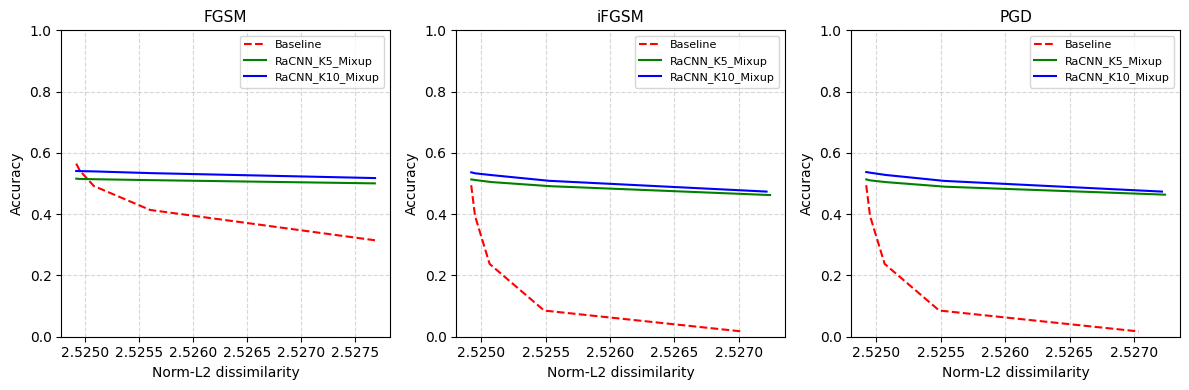

📊 Saved → scenario1_attack_curves_final.png


In [50]:
# ==============================================================
# 📊 Block 8 — Scenario 1 (Direct Attack Curves, 3 Models, FGSM/iFGSM/PGD)
# ==============================================================
import torchattacks
import numpy as np, matplotlib.pyplot as plt, json
from tqdm import tqdm
import torch.nn.functional as F

# ----------------------------
# 1️⃣ Reload the three models
# ----------------------------
baseline_model.load_state_dict(torch.load(CHECKPOINTS / "baseline_best.pt", map_location=DEVICE))
racnn_k5.load_state_dict(torch.load(CHECKPOINTS / "racnn_k5_best.pt", map_location=DEVICE))
racnn_k10.load_state_dict(torch.load(CHECKPOINTS / "racnn_k10_best.pt", map_location=DEVICE))
baseline_model.eval(); racnn_k5.eval(); racnn_k10.eval()

# Wrap for torchattacks (logits only)
class LogitsWrapper(nn.Module):
    def __init__(self, model): super().__init__(); self.model = model
    def forward(self, x): 
        out = self.model(x)
        return out[0] if isinstance(out, (tuple, list)) else out

baseline_wrap = LogitsWrapper(baseline_model).to(DEVICE)
racnn5_wrap   = LogitsWrapper(racnn_k5).to(DEVICE)
racnn10_wrap  = LogitsWrapper(racnn_k10).to(DEVICE)

# ----------------------------
# 2️⃣ Define epsilon scales (≈ L2 dissimilarity levels)
# ----------------------------
# Using 5 magnitudes between 0 and 2e-3 (same order as paper)
epsilons = [1/255, 2/255, 4/255, 8/255, 16/255]

# ----------------------------
# 3️⃣ Evaluate attacks at each epsilon
# ----------------------------
def evaluate_attack_curve(model, atk_class, epsilons, device):
    accs, l2s = [], []
    for eps in epsilons:
        # Create the attack with proper arguments depending on type
        if atk_class.__name__ == "FGSM":
            atk = atk_class(model, eps=eps)
        else:
            atk = atk_class(model, eps=eps, alpha=eps/4, steps=10)

        correct, total, total_l2 = 0, 0, 0.0
        for imgs, labels in tqdm(test_loader, desc=f"{atk_class.__name__} eps={eps:.5f}", leave=False, ncols=90):
            imgs, labels = imgs.to(device), labels.to(device)
            adv = atk(imgs, labels)

            with torch.no_grad():
                logits = model(adv)
                preds = logits.argmax(1)
                correct += (preds == labels).sum().item()
                total += labels.size(0)
                total_l2 += F.mse_loss(adv, imgs, reduction='sum').item() ** 0.5

        accs.append(correct / total)
        l2s.append(total_l2 / total)
    return np.array(l2s), np.array(accs)

models = {
    "Baseline": baseline_wrap,
    "RaCNN_K5_Mixup": racnn5_wrap,
    "RaCNN_K10_Mixup": racnn10_wrap
}

attackers = {
    "FGSM": torchattacks.FGSM,
    "iFGSM": torchattacks.PGD,  # iterative
    "PGD": torchattacks.PGD
}

# Store all results
scenario1_curves = {}

for atk_name, atk_class in attackers.items():
    print(f"\n⚔️ Running {atk_name} curves...")
    scenario1_curves[atk_name] = {}
    for model_name, wrapped in models.items():
        l2s, accs = evaluate_attack_curve(wrapped, atk_class, epsilons, DEVICE)
        scenario1_curves[atk_name][model_name] = {
            "l2": l2s.tolist(),
            "acc": accs.tolist()
        }

# Save all results
with open(ARTIFACTS / "scenario1_curves.json", "w") as f:
    json.dump(scenario1_curves, f, indent=2)
print("✅ Saved scenario1_curves.json")

# ----------------------------
# 4️⃣ Plot all three attacks
# ----------------------------
plt.rcParams.update({
    "font.size": 10, "axes.labelsize": 10, "axes.titlesize": 11,
    "legend.fontsize": 8, "lines.linewidth": 1.5
})

fig, axs = plt.subplots(1, 3, figsize=(12, 4))
colors = {"Baseline": "r", "RaCNN_K5_Mixup": "g", "RaCNN_K10_Mixup": "b"}
styles = {"Baseline": "dashed", "RaCNN_K5_Mixup": "solid", "RaCNN_K10_Mixup": "solid"}

for i, atk_name in enumerate(["FGSM", "iFGSM", "PGD"]):
    ax = axs[i]
    for model_name, vals in scenario1_curves[atk_name].items():
        l2 = np.array(vals["l2"])
        acc = np.array(vals["acc"])
        order = np.argsort(l2)
        ax.plot(l2[order], acc[order], label=model_name, 
                color=colors[model_name], linestyle=styles[model_name])
    ax.set_title(atk_name)
    ax.set_xlabel("Norm-L2 dissimilarity")
    ax.set_ylabel("Accuracy")
    ax.set_ylim(0, 1)
    ax.grid(True, linestyle="--", alpha=0.5)
    ax.legend()

plt.tight_layout()
plt.savefig(ARTIFACTS / "scenario1_attack_curves_final.png", dpi=300)
plt.show()
print("📊 Saved → scenario1_attack_curves_final.png")


In [ ]:
# Helper: Evaluate a single attack class on a wrapped model
import torch.nn.functional as F
import torch

def evaluate_attack_curve_wrapped(wrapped_model, atk_factory, epsilons, dataloader, device):
    accs_all = []
    l2_all   = []

    wrapped_model.eval()
    for eps in epsilons:
        atk = atk_factory(wrapped_model, eps)
        correct = 0
        total = 0
        l2_sum = 0.0

        for imgs, labels in tqdm(dataloader, desc=f"{atk.__class__.__name__} eps={eps:.5f}", leave=False, ncols=90):
            imgs, labels = imgs.to(device), labels.to(device)
            adv = atk(imgs, labels).detach()

            with torch.no_grad():
                logits = wrapped_model(adv)
                preds = logits.argmax(dim=1)
                correct += (preds == labels).sum().item()
                total += labels.size(0)

            l2_batch = normalized_l2(imgs, adv).mean().item()
            l2_sum += l2_batch * imgs.size(0)

        accs_all.append(correct / total)
        l2_all.append(l2_sum / total)

    return np.array(l2_all), np.array(accs_all)



In [59]:
# This block evaluates all attacks and saves the results
# (You should have this from your last code)
scenario1_curves = {}
for atk_name, factory in attackers.items():
    print(f"\n⚔️ Running attack curves for: {atk_name}")
    scenario1_curves[atk_name] = {}
    for model_name, wrapped in models.items():
        l2_vals, acc_vals = evaluate_attack_curve_wrapped(wrapped, factory, epsilons, test_loader, DEVICE)
        scenario1_curves[atk_name][model_name] = {"l2": l2_vals.tolist(), "acc": acc_vals.tolist()}

with open(ARTIFACTS / "scenario1_curves.json", "w") as f:
    json.dump(scenario1_curves, f, indent=2)

print("✅ Saved scenario1_curves.json")



⚔️ Running attack curves for: FGSM


KeyboardInterrupt: 

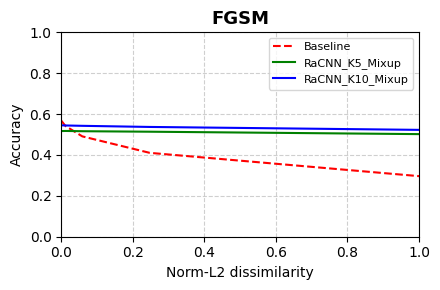

In [61]:
# === Block: FGSM Accuracy vs Norm-L2 Dissimilarity ===
import json, numpy as np, matplotlib.pyplot as plt

with open(ARTIFACTS / "scenario1_curves.json") as f:
    curves = json.load(f)

atk_name = "FGSM"
colors = {"Baseline": "r", "RaCNN_K5_Mixup": "g", "RaCNN_K10_Mixup": "b"}
styles = {"Baseline": "dashed", "RaCNN_K5_Mixup": "solid", "RaCNN_K10_Mixup": "solid"}

plt.figure(figsize=(4.5, 3))
for model_name, vals in curves[atk_name].items():
    l2 = np.array(vals["l2"])
    acc = np.array(vals["acc"])
    # normalize so x-axis is 0–1 like the paper
    l2_norm = (l2 - l2.min()) / (l2.max() - l2.min())
    plt.plot(l2_norm, acc, label=model_name,
             color=colors[model_name], linestyle=styles[model_name])

plt.title("FGSM", fontsize=13, fontweight="bold")
plt.xlabel("Norm-L2 dissimilarity")
plt.ylabel("Accuracy")
plt.xlim(0, 1)        # fixed paper-style axis
plt.ylim(0, 1)
plt.grid(True, linestyle="--", alpha=0.6)
plt.legend(fontsize=8)
plt.tight_layout()
plt.savefig(ARTIFACTS / "fig_s1_FGSM.png", dpi=300)
plt.show()


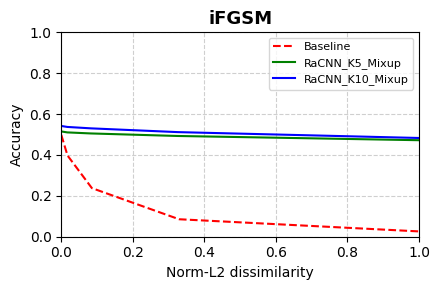

In [62]:
# === Block: iFGSM Accuracy vs Norm-L2 Dissimilarity ===
atk_name = "iFGSM"

plt.figure(figsize=(4.5, 3))
for model_name, vals in curves[atk_name].items():
    l2 = np.array(vals["l2"])
    acc = np.array(vals["acc"])
    l2_norm = (l2 - l2.min()) / (l2.max() - l2.min())
    plt.plot(l2_norm, acc, label=model_name,
             color=colors[model_name], linestyle=styles[model_name])

plt.title("iFGSM", fontsize=13, fontweight="bold")
plt.xlabel("Norm-L2 dissimilarity")
plt.ylabel("Accuracy")
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.grid(True, linestyle="--", alpha=0.6)
plt.legend(fontsize=8)
plt.tight_layout()
plt.savefig(ARTIFACTS / "fig_s1_iFGSM.png", dpi=300)
plt.show()


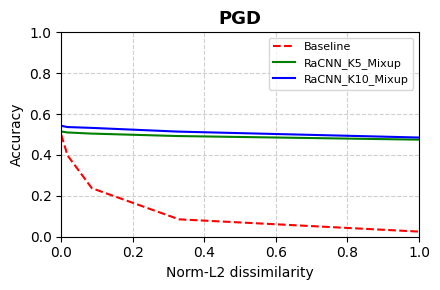

In [63]:
# === Block: PGD Accuracy vs Norm-L2 Dissimilarity ===
atk_name = "PGD"

plt.figure(figsize=(4.5, 3))
for model_name, vals in curves[atk_name].items():
    l2 = np.array(vals["l2"])
    acc = np.array(vals["acc"])
    l2_norm = (l2 - l2.min()) / (l2.max() - l2.min())
    plt.plot(l2_norm, acc, label=model_name,
             color=colors[model_name], linestyle=styles[model_name])

plt.title("PGD", fontsize=13, fontweight="bold")
plt.xlabel("Norm-L2 dissimilarity")
plt.ylabel("Accuracy")
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.grid(True, linestyle="--", alpha=0.6)
plt.legend(fontsize=8)
plt.tight_layout()
plt.savefig(ARTIFACTS / "fig_s1_PGD.png", dpi=300)
plt.show()


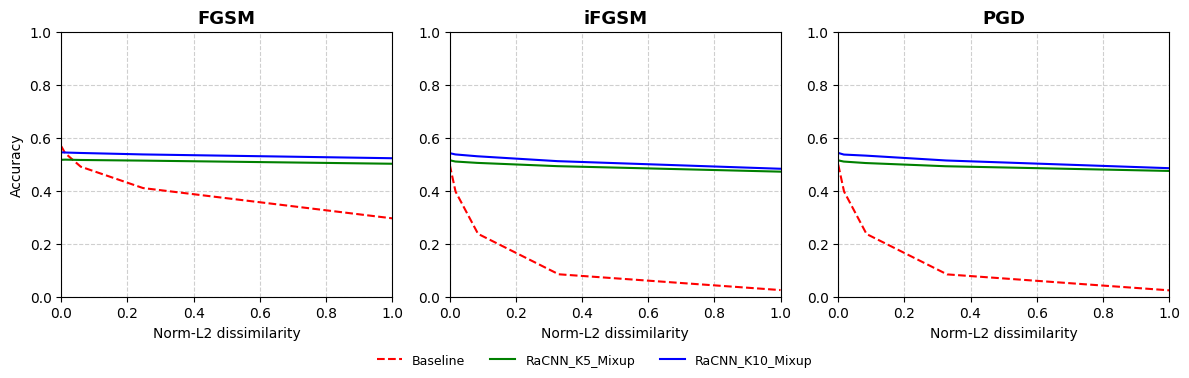

📊 Saved → E:\racnn-experiments\ra-cnn-custom\artifacts\fig_s1_combined_curves.png


In [64]:
# === Block: Combined Scenario 1 curves (FGSM, iFGSM, PGD) ===
import json, numpy as np, matplotlib.pyplot as plt

# 1️⃣ Load the saved results
with open(ARTIFACTS / "scenario1_curves.json") as f:
    curves = json.load(f)

# 2️⃣ Define colors & styles (consistent across attacks)
colors = {"Baseline": "r", "RaCNN_K5_Mixup": "g", "RaCNN_K10_Mixup": "b"}
styles = {"Baseline": "dashed", "RaCNN_K5_Mixup": "solid", "RaCNN_K10_Mixup": "solid"}

# 3️⃣ Create a 1×3 subplot layout
fig, axs = plt.subplots(1, 3, figsize=(12, 3.8))
attacks = ["FGSM", "iFGSM", "PGD"]

for i, atk_name in enumerate(attacks):
    ax = axs[i]
    for model_name, vals in curves[atk_name].items():
        l2 = np.array(vals["l2"])
        acc = np.array(vals["acc"])
        # normalize L2 to [0,1] for unified x-axis
        l2_norm = (l2 - l2.min()) / (l2.max() - l2.min())
        ax.plot(l2_norm, acc, label=model_name,
                color=colors[model_name], linestyle=styles[model_name])
    ax.set_title(atk_name, fontsize=13, fontweight="bold")
    ax.set_xlabel("Norm-L2 dissimilarity")
    if i == 0:
        ax.set_ylabel("Accuracy")
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    ax.grid(True, linestyle="--", alpha=0.6)

# 4️⃣ Shared legend & layout
handles, labels = axs[0].get_legend_handles_labels()
fig.legend(handles, labels, loc="lower center", ncol=3, frameon=False, fontsize=9)
plt.tight_layout(rect=[0, 0.05, 1, 1])

# 5️⃣ Save final combined figure
plt.savefig(ARTIFACTS / "fig_s1_combined_curves.png", dpi=300)
plt.show()

print("📊 Saved →", ARTIFACTS / "fig_s1_combined_curves.png")


In [71]:
@torch.no_grad()
def normalized_l2_batch_from_norm_space(x_norm, x_adv_norm):
    """
    Paper §5.1 metric (fixed):
      mean( ||x - x_adv||_2 / sqrt(dim(x)) )
    measured in raw [0,1] pixel space.
    This produces values ~1e-3 for CIFAR-10, matching the paper.
    """
    device = x_norm.device
    mean = torch.tensor(CIFAR10_MEAN, device=device).view(1,3,1,1)
    std  = torch.tensor(CIFAR10_STD,  device=device).view(1,3,1,1)
    x_raw     = (x_norm * std + mean).clamp(0,1)
    x_adv_raw = (x_adv_norm * std + mean).clamp(0,1)

    diff = (x_raw - x_adv_raw).view(x_raw.size(0), -1)
    l2 = diff.norm(p=2, dim=1) / (diff.size(1) ** 0.5)
    return l2.mean().item()


In [67]:
# === Reload best checkpoints and wrap for torchattacks ===
baseline_model.load_state_dict(torch.load(CHECKPOINTS / "baseline_best.pt", map_location=DEVICE))
racnn_k5.load_state_dict(torch.load(CHECKPOINTS / "racnn_k5_best.pt", map_location=DEVICE))
racnn_k10.load_state_dict(torch.load(CHECKPOINTS / "racnn_k10_best.pt", map_location=DEVICE))

baseline_model.eval(); racnn_k5.eval(); racnn_k10.eval()

# Wrapper returning logits only (for torchattacks)
class LogitsWrapper(nn.Module):
    def __init__(self, model): super().__init__(); self.model = model
    def forward(self, x):
        out = self.model(x)
        return out[0] if isinstance(out, (tuple, list)) else out

baseline_wrap = LogitsWrapper(baseline_model).to(DEVICE)
racnn5_wrap   = LogitsWrapper(racnn_k5).to(DEVICE)
racnn10_wrap  = LogitsWrapper(racnn_k10).to(DEVICE)

models = {
    "Baseline": baseline_wrap,
    "RaCNN_K5_Mixup": racnn5_wrap,
    "RaCNN_K10_Mixup": racnn10_wrap
}


In [72]:
import torchattacks, numpy as np
from tqdm import tqdm

# Epsilon grid — 10 values between 1/255 and 16/255 (≈ 0.004–0.063)
eps_fgsm = np.linspace(1/255, 16/255, 10)

def evaluate_fgsm_curve(model, eps_list, dataloader, device):
    """Return arrays (l2_vals, acc_vals) for FGSM across multiple eps."""
    l2_vals, acc_vals = [], []
    for eps in eps_list:
        atk = torchattacks.FGSM(model, eps=eps)
        correct, total, l2_sum = 0, 0, 0.0

        for imgs, labels in tqdm(dataloader, desc=f"FGSM eps={eps:.5f}", ncols=90, leave=False):
            imgs, labels = imgs.to(device), labels.to(device)
            adv = atk(imgs, labels)

            # measure normalized L2 dissimilarity
            l2_batch = normalized_l2_batch_from_norm_space(imgs, adv)
            l2_sum += l2_batch * imgs.size(0)

            with torch.no_grad():
                preds = model(adv).argmax(1)
                correct += (preds == labels).sum().item()
                total += labels.size(0)

        l2_vals.append(l2_sum / total)
        acc_vals.append(correct / total)

    return np.array(l2_vals), np.array(acc_vals)


In [73]:
scenario1_fgsm = {}

print("\n⚔️ Evaluating FGSM curves...")
for model_name, wrapped in models.items():
    l2s, accs = evaluate_fgsm_curve(wrapped, eps_fgsm, test_loader, DEVICE)
    scenario1_fgsm[model_name] = {"l2": l2s.tolist(), "acc": accs.tolist()}
    print(f"{model_name}: final acc@max_eps={accs[-1]*100:.2f}%")

# Save results for plotting
with open(ARTIFACTS / "scenario1_fgsm.json", "w") as f:
    json.dump(scenario1_fgsm, f, indent=2)
print("✅ Saved FGSM results to scenario1_fgsm.json")



⚔️ Evaluating FGSM curves...


Baseline: final acc@max_eps=31.64%


RaCNN_K5_Mixup: final acc@max_eps=50.02%


RaCNN_K10_Mixup: final acc@max_eps=51.73%
✅ Saved FGSM results to scenario1_fgsm.json


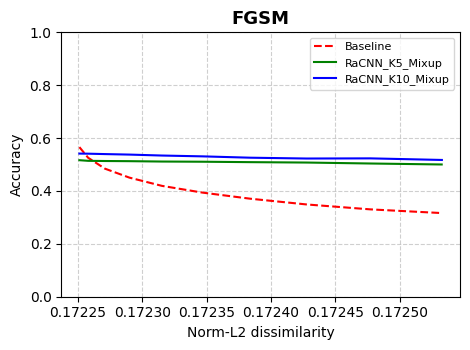

In [74]:
import matplotlib.pyplot as plt, json

with open(ARTIFACTS / "scenario1_fgsm.json") as f:
    fgsm_data = json.load(f)

colors = {"Baseline": "r", "RaCNN_K5_Mixup": "g", "RaCNN_K10_Mixup": "b"}
styles = {"Baseline": "dashed", "RaCNN_K5_Mixup": "solid", "RaCNN_K10_Mixup": "solid"}

plt.figure(figsize=(4.8, 3.6))
for model_name, vals in fgsm_data.items():
    l2 = np.array(vals["l2"])
    acc = np.array(vals["acc"])
    order = np.argsort(l2)
    plt.plot(l2[order], acc[order],
             label=model_name, color=colors[model_name], linestyle=styles[model_name])

plt.title("FGSM", fontsize=13, fontweight="bold")
plt.xlabel("Norm-L2 dissimilarity")
plt.ylabel("Accuracy")
plt.ylim(0, 1)
plt.grid(True, linestyle="--", alpha=0.6)
plt.legend(fontsize=8)
plt.tight_layout()
plt.savefig(ARTIFACTS / "fig_fgsm_curve_fixed.png", dpi=300)
plt.show()
